## Face Recognition Model

- Using Simple CNN model with data augumentation achieves 96%

## Movie Review Sentiment Analysis

- Using Logistic Regression achieves 88%


In [1]:
from sklearn.datasets import fetch_olivetti_faces
from google.colab.patches import cv2_imshow
import numpy as np
import keras
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Olivetti faces dataset (AT&T Laboratories Cambridge)

As described on the original website:

"_There are ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement)._"

The original dataset consisted of 92 x 112, while the version available here consists of 64x64 images.

- Classes: 40
- Samples per class: 10
- Samples total: 400
- Dimensionality: 4096 (64x64 pixels)
- Pixel values: real, between 0 and 1


## Get the dataset


In [2]:
faces = fetch_olivetti_faces()

_, img_height, img_width = faces.images.shape

print(faces.images.shape)

(400, 64, 64)


## Split the dataset


In [3]:
from sklearn.model_selection import train_test_split

N_IDENTITIES = len(np.unique(faces.target)) # how many different individuals are in the dataset

GALLERY_SIZE = 8

def split(N_IDENTITIES, GALLERY_SIZE, validation_size=0.15):
    gallery_indices = []
    probe_indices = []

    for i in range(N_IDENTITIES):
        indices = list(np.where(faces.target == i)[0])
        np.random.shuffle(indices)  # Shuffle the indices for each identity
        gallery_indices += indices[:GALLERY_SIZE]
        probe_indices += indices[GALLERY_SIZE:]

    x_train = faces.images[gallery_indices]
    y_train = faces.target[gallery_indices]

    x_test = faces.images[probe_indices]
    y_test = faces.target[probe_indices]

    # Shuffle the training set before splitting into train and validation
    train_indices = np.arange(len(x_train))
    np.random.shuffle(train_indices)
    x_train = x_train[train_indices]
    y_train = y_train[train_indices]

    x_val = x_train[:int(validation_size * len(x_train))]
    y_val = y_train[:int(validation_size * len(y_train))]
    x_train = x_train[int(validation_size * len(x_train)):]
    y_train = y_train[int(validation_size * len(y_train)):]

    return x_train, y_train, x_test, y_test, x_val, y_val

x_train, y_train, x_test, y_test, x_val, y_val = split(N_IDENTITIES, 8)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape)

(272, 64, 64) (272,) (80, 64, 64) (80,) (48, 64, 64) (48,)


In [4]:
# Increase the rank to fit the tensor format
x_train = np.expand_dims(x_train, 3)
x_train.shape

(272, 64, 64, 1)

## Report results


In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf

model = Sequential([
    # First Layer
    Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    # Second Layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(40, activation='softmax')
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 31, 31, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 32)        0

In [6]:
learning_rate = 0.001
loss_function = 'sparse_categorical_crossentropy'
batch_size = 64
num_epochs = 150

In [7]:
# training configuration
optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

Epoch 1/150
5/5 [==============================] - 2s 96ms/step - loss: 0.2102 - accuracy: 0.9412 - val_loss: 0.3915 - val_accuracy: 0.8958
Epoch 2/150
5/5 [==============================] - 0s 33ms/step - loss: 0.2264 - accuracy: 0.9265 - val_loss: 0.3296 - val_accuracy: 0.9167
Epoch 3/150
5/5 [==============================] - 0s 18ms/step - loss: 0.1799 - accuracy: 0.9596 - val_loss: 0.3388 - val_accuracy: 0.8750
Epoch 4/150
5/5 [==============================] - 0s 21ms/step - loss: 0.1601 - accuracy: 0.9743 - val_loss: 0.4156 - val_accuracy: 0.8125
Epoch 5/150
5/5 [==============================] - 0s 21ms/step - loss: 0.2110 - accuracy: 0.9338 - val_loss: 0.3720 - val_accuracy: 0.8750
Epoch 6/150
5/5 [==============================] - 0s 16ms/step - loss: 0.1530 - accuracy: 0.9669 - val_loss: 0.5366 - val_accuracy: 0.8542
Epoch 7/150
5/5 [==============================] - 0s 16ms/step - loss: 0.1619 - accuracy: 0.9596 - val_loss: 0.3368 - val_accuracy: 0.8958
Epoch 8/150
5/5 [===

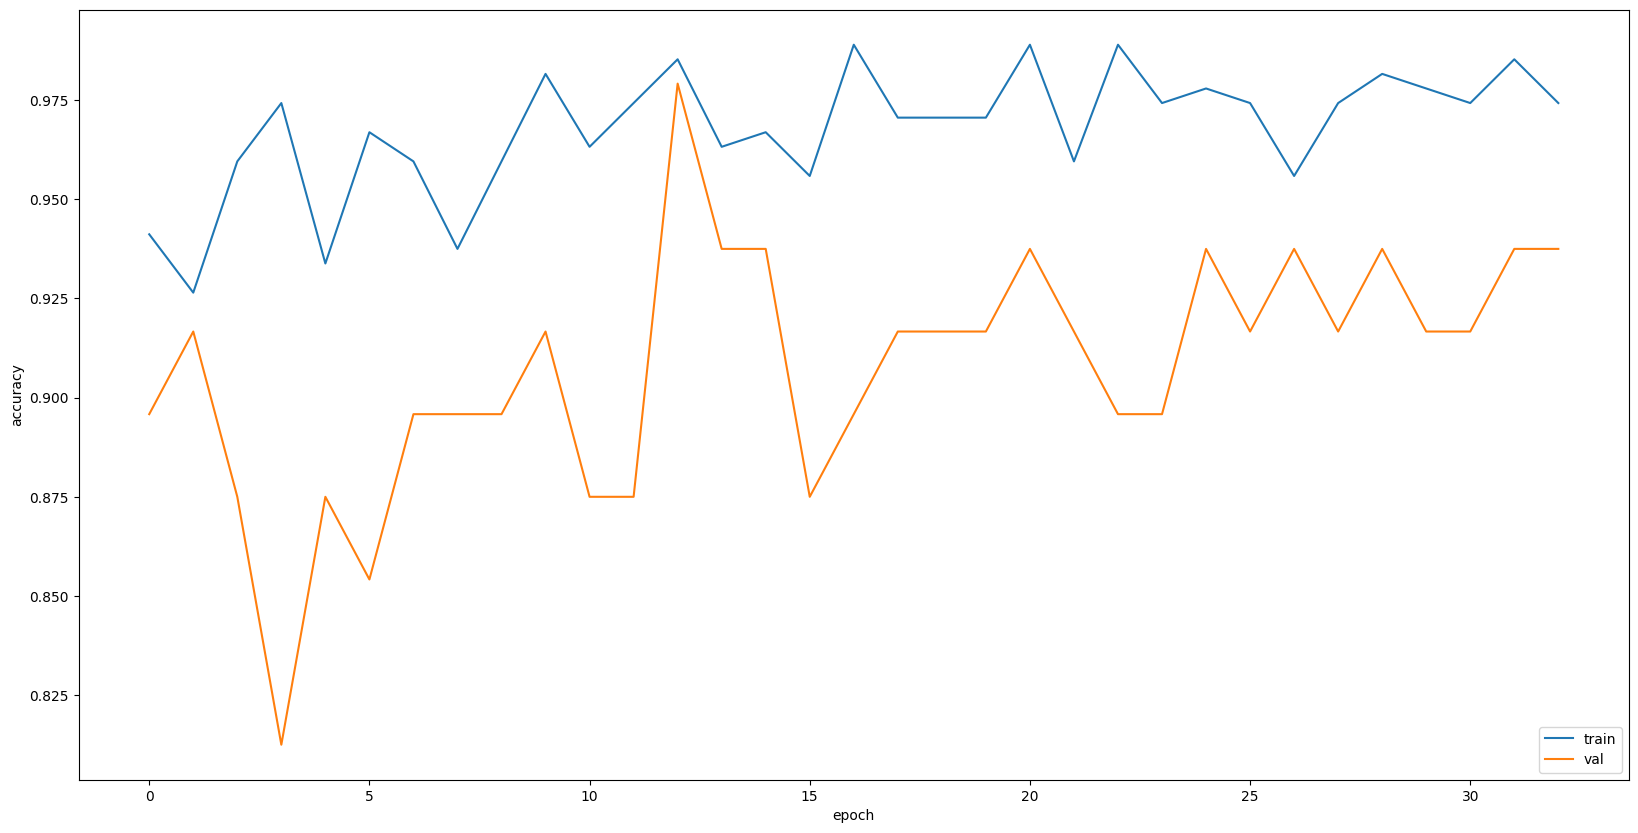

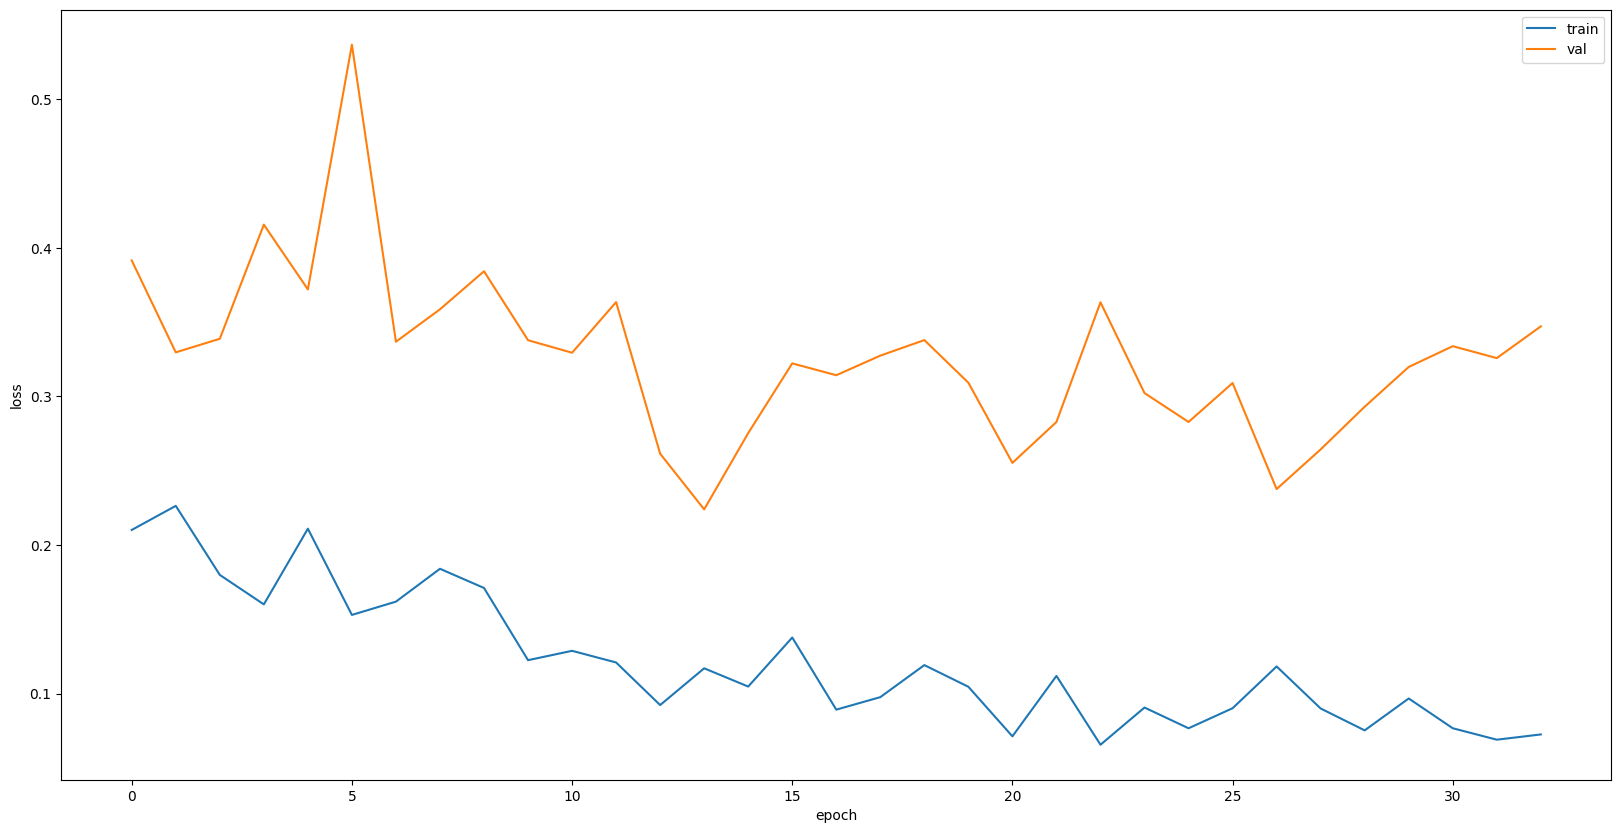

TRAINING SET
Loss: 0.00454055517911911 
Accuracy: 1.0

VALIDATION SET
Loss: 0.2614544928073883 
Accuracy: 0.9791666865348816

TEST SET
Loss: 0.1866680532693863 
Accuracy: 0.9624999761581421


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, verbose=1)
model_save = keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)

steps_for_epoch = np.ceil(x_train.shape[0] / batch_size)
history = model.fit(x=x_train,y=y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(x_val, y_val), callbacks=[early_stop, model_save])


plt.rcParams["figure.figsize"] = (20,10)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

scores = model.evaluate(x_train, y_train, verbose=0)
print('TRAINING SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(x_val, y_val, verbose=0)
print('\nVALIDATION SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(x_test, y_test, verbose=0)
print('\nTEST SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

In [8]:
# Load model back (Load the best model I submit)
model.load_weights('best_model_best.h5')

In [9]:
x_train.shape, x_val.shape

((272, 64, 64, 1), (48, 64, 64))

In [10]:
x_val = np.expand_dims(x_val, 3)

In [12]:
x_test = np.expand_dims(x_test, 3)

In [13]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

scores = model.evaluate(x_train, y_train, verbose=0)
print('TRAINING SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(x_val, y_val, verbose=0)
print('\nVALIDATION SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(x_test, y_test, verbose=0)
print('\nTEST SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

TRAINING SET
Loss: 0.0416116788983345 
Accuracy: 0.9963235259056091

VALIDATION SET
Loss: 0.026240291073918343 
Accuracy: 1.0

TEST SET
Loss: 0.20175477862358093 
Accuracy: 0.9624999761581421


# IMDB Movie Review Dataset

Description from https://www.tensorflow.org/datasets/catalog/imdb_reviews:

> Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.


In [ ]:
import tensorflow_datasets
import numpy as np

Load dataset


In [ ]:
dataset, info = tensorflow_datasets.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteHRA0XF/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteHRA0XF/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteHRA0XF/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
x_train = []
y_train = []

for sample, label in train_dataset:
  x_train.append(sample.numpy())
  y_train.append(label.numpy())

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

print(x_train[0])
print(y_train[0])

x_test = []
y_test = []

for sample, label in test_dataset:
  x_test.append(sample.numpy())
  y_test.append(label.numpy())

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

print(x_test[0])
print(y_test[0])

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
0
b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of th

### Clean data


In [ ]:
import numpy as np
import tensorflow_datasets as tfds
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')

def preprocess_text(text):
    text = text.decode("utf-8")


    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)


    text = text.lower()

    tokens = text.split()

    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

# Preprocess and vectorize the training data
x_train = [preprocess_text(sample.numpy()) for sample, _ in train_dataset]
y_train = [label.numpy() for _, label in train_dataset]

# Vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
x_train_tfidf = vectorizer.fit_transform(x_train).toarray()


x_test = [preprocess_text(sample.numpy()) for sample, _ in test_dataset]
y_test = [label.numpy() for _, label in test_dataset]

x_test_tfidf = vectorizer.transform(x_test).toarray()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

clf.fit(x_train_tfidf, y_train)

LogisticRegression()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

predictions = clf.predict(x_test_tfidf)

print('The accuracy score is:',accuracy_score(y_test,predictions))
print('The confusion matrix is:','\n',confusion_matrix(y_test,predictions))
print('The classification report is:','\n',classification_report(y_test,predictions))

The accuracy score is: 0.87636
The confusion matrix is: 
 [[10952  1548]
 [ 1543 10957]]
The classification report is: 
               precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [ ]:
import pickle

In [ ]:
# Save model
with open('logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(clf, file)

In [ ]:
# Load the model from the file
with open('logistic_regression_model_best.pkl', 'rb') as file:
    clf_loaded = pickle.load(file)

In [ ]:
predictions = clf_loaded.predict(x_test_tfidf)

print('The accuracy score is:',accuracy_score(y_test,predictions))
print('The confusion matrix is:','\n',confusion_matrix(y_test,predictions))
print('The classification report is:','\n',classification_report(y_test,predictions))

The accuracy score is: 0.87636
The confusion matrix is: 
 [[10952  1548]
 [ 1543 10957]]
The classification report is: 
               precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

